# SMALL-FOOTPRINT KEYWORD SPOTTING
## *4. DEMO*

Finally, it was implemented a little demo version for this Speech recognition. The objective is to use a trained model and generate real time .wav files and see the accuracy of the model. 

In [1]:
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from IPython import display
from utilities import*
import time
from memory_profiler import profile
from keras import layers as L
from keras.models import Model
from keras import backend as K
import pyaudio
import numpy as np

2024-07-13 23:14:58.837550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 23:14:58.837623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 23:14:58.886251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-13 23:14:58.984736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 23:14:59.942481: W tensorflow/compiler/tf2

# 1. Model Loading

In [2]:
# Load model
stft_100 = tf.keras.models.load_model("SIFT_RNN_40.keras", safe_mode = False)

2024-07-13 23:15:04.444644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 23:15:04.619570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 23:15:04.621646: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
audio_labels = ['backward', 'bed', 'bird','cat','dog','down','eight','five','follow','forward','four',
 'go','happy','house','learn','left','marvin','nine','no','off','on','one','right','seven','sheila',
 'six','stop','three','tree','two','up','visual','wow','yes','zero']

# 2. Test Model

## **2.1 Approach A**

For approach A, we record a 2 seconds.wav file and transform it into a spectogram. First, record word using soundfile library:

In [4]:
# define sampling frequency
freq = 16000
# define duration
duration = 1.2
# record voice
recording = sd.rec(int(duration*freq), samplerate = freq, channels =1)
sd.wait()
# save .wav filed
write("recording.wav", freq, recording)

Then refined audio file removing silenced part from the beggining.

In [5]:
# refine .wav file
recording_refined = shorten_wav(recording)
recording_refined = np.int16(recording_refined / np.max(np.abs(recording_refined)) * 32767)
write("recording_r.wav", freq, recording_refined)

Finally, display audios.

Play original recording:


Play refined recording:


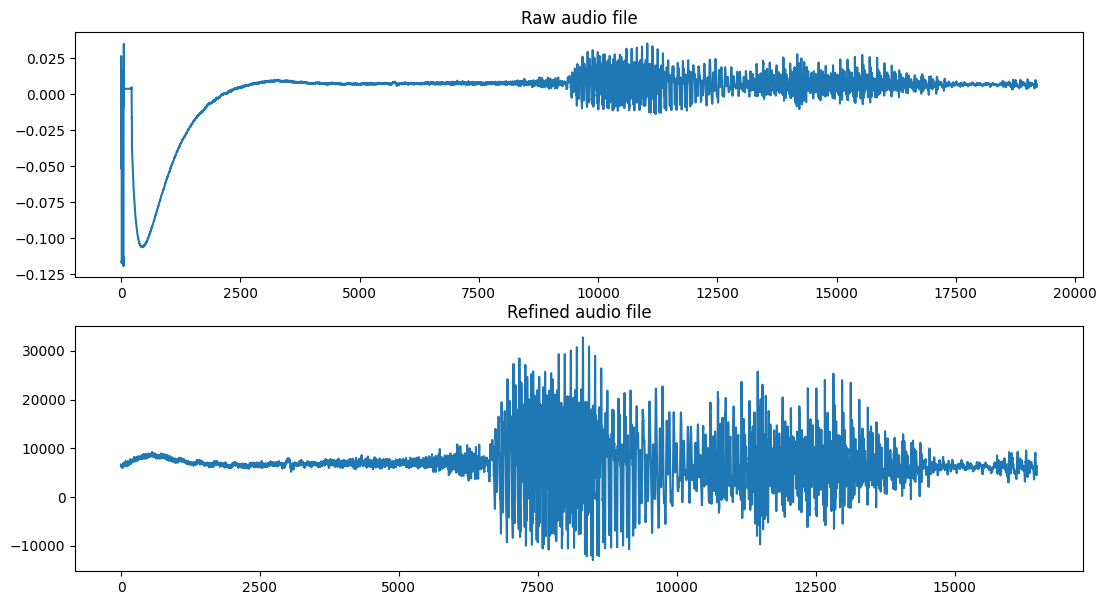

In [7]:
fig, axis = plt.subplots(2, 1, figsize=(13,7))
axis[0].plot(recording)
axis[0].set_title("Raw audio file")
axis[1].plot(recording_refined)
axis[1].set_title("Refined audio file")

# Reproduce sample
print("Play original recording:")
display.display(display.Audio(("recording.wav")))
print("Play refined recording:")
display.display(display.Audio(("recording_r.wav")))

Convert .wav into spectrogram and feed it into the desired model

In [8]:
def get_spectogram(wav_file, wav_lenght, wav_feature):
    """
    Convert wav file into a spectogram with the desired feature

    Inputs:
        wav_file <- .wav file in numpy format
        wav_length <- size of the wav file
        wav_feature <- select feature to use for audio classification

    Output
        spectogram <- spectogram with the desired feature
    """
    # Compute needed length
    if wav_file.shape[0]>= 16000:
        extended_wav = wav_file[:16000].squeeze()
    else:
        padding_length =  wav_lenght - wav_file.shape[0]
        extended_wav = np.concatenate((wav_file.squeeze(), np.zeros(padding_length)))
    # Create spectrogram
    if wav_feature == "STFT":
        spectogram = tf.signal.stft(extended_wav, frame_length = 256, frame_step = 128)
        spectogram = tf.abs(spectogram)
        spectogram = spectogram[..., tf.newaxis]
        spectogram = tf.reshape(spectogram,(1,124, 129))

    return spectogram

In [9]:
word, smp_rate = tf.audio.decode_wav(tf.io.read_file("recording_r.wav"), desired_channels=1)
spectogram = get_spectogram(word.numpy(), 16000, "STFT")

In [10]:
audio_labels[np.argmax(stft_100.predict(spectogram))]

2024-07-13 23:15:26.768248: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 1s 1s/step


'forward'

## **2.2 Approach B**

For this approach, we used another method that records continously until we say the word stop. For this we use pyaudio libraries.

In [13]:
# Define function for normalizing wave
def preprocess(wave):
    wave = wave / 32768
    spectogram = get_spectogram(wave, 16000, "STFT")
    return spectogram

# Define function for recording audio
def record_audio():
    stream = p.open(
        format = FORMAT,
        channels = CHANNELS,
        rate = RATE, 
        input = True,
        frames_per_buffer = FRAMES_PER_BUFFER
    )

    frames = []
    seconds = 1.2
    for i in range(0, int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)

    stream.stop_stream()
    stream.close()
    return np.frombuffer(b''.join(frames), dtype = np.int16)


# Prediction function
def predict_mic():
    audio = record_audio()
    spec = preprocess(audio)
    prediction = stft_100(spec)
    label = audio_labels[np.argmax(prediction)]
    print(f"You just said:{label}") 
    return label

def terminate():
    p.terminate()

In [14]:
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
p = pyaudio.PyAudio()

while True:
    command = predict_mic()
    if command == "stop":
        terminate()
        break

You just said:forward
You just said:up
You just said:down
You just said:right
You just said:wow
You just said:eight
You just said:marvin
You just said:up
You just said:stop
